# An Initial Model

First attempt at God's Eye 

**IMPORTS:**

In [1]:
!pip install torchviz
!pip install pycoco
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import gdown

import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
import json


     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=a18cbbf944563dc65191999f6c5b502d1759f68f9768d268b251aa355726191f
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 706kB 3.9MB/s 
     |████████████████████████████████| 409kB 38.1MB/s 
  Created wheel for pycoco: filename=pycoco-0.7.2-cp36-none-any.whl size=9791 sha256=07a77a3c4cff96a8cb77953a4e990f246170fec80446a4bd69ef4bc45caee3a3
  Stored in directory: /root/.cache/pip/wheels/d5/9f/9c/6f40b261f0abad9f29cfe967547d036e4bcfa6a225e442a678
  Created wheel for ll-xist: filename=ll_xist-5.53-cp36-cp36m-linux_x86_64.whl size=606479 sha256=216e229e78de871ae062f352099c7182ccfd9e69e3fcd738ef60b04423d423a4
  Stored in directory: /root/.cache/pip/wheels/66/23/56/de77a624279e15511955acd3a02fa8deece242ffbffc66d781
Successfully built 

**DOWNLOADS AND EXTRACTION:**

In [0]:
!mkdir /data

In [3]:
gdown.download('https://drive.google.com/uc?id=1zvKtRYaP_BxCS83LYZc3DWc4RyVeqJEF&export=download',
               '/content/godseyedata.zip',
               quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1zvKtRYaP_BxCS83LYZc3DWc4RyVeqJEF&export=download
To: /content/godseyedata.zip
6.01GB [01:13, 81.3MB/s]


'/content/godseyedata.zip'

In [0]:
!unzip -qq 'godseyedata.zip' -d /data



```
```

# Pre-processing

In [0]:
import imageio
ext = ('.jpg','.png')

In [28]:
# Data set information
image_dims = 3, 256, 256
n_training_samples = 8001 # How many training images to use
n_test_samples = 2000 # How many test images to use
classes = ('Alabama','Alaska','Arizona','Arkansas','California','Colorado',
           'Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho',
           'Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
           'Maryland','Massachusetts','Michigan','Minnesota','Mississippi',
           'Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
           'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma',
           'Oregon','Pennsylvania', 'Rhode Island','South Carolina','South Dakota',
           'Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
           'Wisconsin','Wyoming')

for state in classes:
  root = '/data/' + state
  # Load the training set
  train_set = torchvision.datasets.DatasetFolder(
      root=root, loader=imageio.imread, extensions=ext, transform=transforms.ToTensor(), target_transform=None, is_valid_file=None)
  train_sampler = SubsetRandomSampler(
      np.arange(n_training_samples, dtype=np.int64))

  classes = train_set._find_classes('/data')[0]

  #Load the test set
  test_set = torchvision.datasets.DatasetFolder(
      root=root, loader=imageio.imread, extensions=ext, transform=transforms.ToTensor(), target_transform=None, is_valid_file=None)
  test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

RuntimeError: ignored

In [26]:
#train_set.root = '/content/Alabama'

for i in range(5):
  x, y = train_set[i]
  print(y)
train_set._find_classes('/data')[0]

print(train_sampler)
print(test_sampler[100])

0
0
0
0
0


AttributeError: ignored

**IMAGE DISPLAY:**

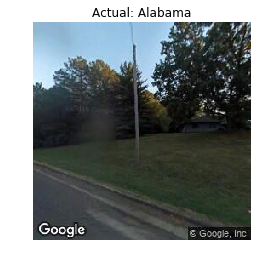

torch.Size([3, 256, 256])


In [8]:
def disp_image(image, class_idx, predicted=None):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    if predicted:
        plt.title("Actual: " + classes[class_idx] + "     Predicted: " + classes[predicted])
    else:
        plt.title("Actual: " + classes[class_idx])
    plt.show()

#print("training set input data shape", train_set.data.shape)
#print("Number of training outputs", len(train_set.targets))
x, y = train_set[1]
disp_image(x,y)
print(x.shape)

**UNDERSTANDING THE DATA:**

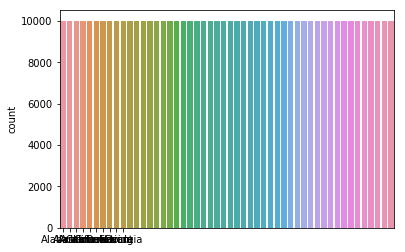

In [9]:
import seaborn as sns

sns.countplot(train_set.targets)
plt.xticks(ticks=range(10), labels=classes)
plt.show()



```
```

# Building the Network

**Network Class:**

In [0]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here

        # Make sure you understand what this convolutional layer is doing.
        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.

        # note: image_dims[0] will be 3 as there are 3 color channels (R, G, B)
        num_kernels = 16
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

        # Make sure you understand what this MaxPool2D layer is doing.
        # E.g., considering looking at help(nn.MaxPool2d).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  We have an exercise that asks you to explain why the line of
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

**Model the Network:**

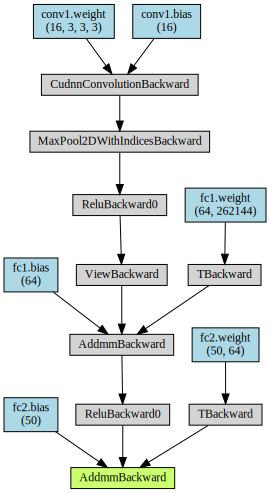

In [11]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

visualize_network(net)

**Train the model:**

In [0]:
# Define training parameters
batch_size = 32
learning_rate = 1e-2
n_epochs = 10
# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, sampler=test_sampler, num_workers=2)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [13]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 0.20 took: 2.57s
Epoch 1, Iteration 40	 train_loss: 0.00 took: 2.17s
Epoch 1, Iteration 60	 train_loss: 0.00 took: 2.13s
Epoch 1, Iteration 80	 train_loss: 0.00 took: 2.13s
Epoch 1, Iteration 100	 train_loss: 0.00 took: 2.05s
Epoch 1, Iteration 120	 train_loss: 0.00 took: 2.06s
Epoch 1, Iteration 140	 train_loss: 0.00 took: 2.00s
Epoch 1, Iteration 160	 train_loss: 0.00 took: 1.96s
Epoch 1, Iteration 180	 train_loss: 0.00 took: 1.78s
Epoch 1, Iteration 200	 train_loss: 0.00 took: 1.88s
Epoch 1, Iteration 220	 train_loss: 0.00 took: 1.79s
Epoch 1, Iteration 240	 train_loss: 0.00 took: 1.95s
Validation loss = 0.00
Epoch 2, Iteration 20	 train_loss: 0.00 took: 2.08s
Epoch 2, Iteration 40	 train_loss: 0.00 took: 1.76s
Epoch 2, Iteration 60	 train_loss: 0.00 took: 1.72s
Epoch 2, Iteration 80	 train_loss: 0.00 took: 1.81s


KeyboardInterrupt: ignored

**Loss over time:**

In [0]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

In [0]:
def examine_label(idx):
    image, label = test_set[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    disp_image(image, label, prediction)

examine_label(20)

In [0]:
n_correct = 0
n_total = 0
for i, data in enumerate(train_loader, 0):
    # Get inputs in right form
    inputs, labels = data
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    # Forward pass
    outputs = net(inputs)
    n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
    n_total += labels.shape[0]
print("Training accuracy is", n_correct/n_total)

In [0]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))

In [0]:
plt.subplots(4, 4)
for i in range(net.conv1.weight.shape[0]):
    plt.subplot(4, 4, i+1)
    kernel = net.conv1.weight[i].cpu().detach().numpy()
    im = kernel.mean(axis=0)
    plt.pcolor(im, cmap='gray')
plt.show()